<a href="https://colab.research.google.com/github/flediak/tensor_flow_image_classification/blob/main/cifar10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# intro
This notebook classifies images of the CIFAR-10 dataset using 4 different neural networks. The networks are build with Tensor Flow and fitted using GPU acceleration. Finally the model performances are compared and tested for overfitting. These tests show that using convolutions of the input images
(i.e. Convolutional Neural Networks) improves the performance, but also leads to strong overfitting. The overfitting can be reduced by introducing dropout layers in the network and training on augmented data.

In [1]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

In [3]:
np.random.seed(1234)

In [4]:
print(tf.__version__)

2.8.0


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# read data

In [6]:
from keras.datasets import cifar10

In [7]:
(X_train, Y_train), (X_val, Y_val) = cifar10.load_data()

In [8]:
X_train.shape, X_val.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [9]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [10]:
### for binary classification

'''
class1_name="cat"
class2_name="airplane"

# get IDs of class 1 and 2
class1_ID = np.arange(len(class_names))[np.array(class_names)==class1_name][0]
class2_ID = np.arange(len(class_names))[np.array(class_names)==class2_name][0]

# select the two classes from input data
select_train = (Y_train == class1_ID) | (Y_train == class2_ID)
select_test = (Y_test == class1_ID) | (Y_test == class2_ID)

X_train = X_train[select_train[:,0]]
Y_train = Y_train[select_train[:,0]]

X_test = X_test[select_test[:,0]]
Y_test = Y_test[select_test[:,0]]

# reset class values to 0 and 1 for class 1 and 2
Y_train = np.where(Y_train==class1_ID,0,1)
Y_test = np.where(Y_test==class1_ID,0,1)
'''

'\nclass1_name="cat"\nclass2_name="airplane"\n\n# get IDs of class 1 and 2\nclass1_ID = np.arange(len(class_names))[np.array(class_names)==class1_name][0]\nclass2_ID = np.arange(len(class_names))[np.array(class_names)==class2_name][0]\n\n# select the two classes from input data\nselect_train = (Y_train == class1_ID) | (Y_train == class2_ID)\nselect_test = (Y_test == class1_ID) | (Y_test == class2_ID)\n\nX_train = X_train[select_train[:,0]]\nY_train = Y_train[select_train[:,0]]\n\nX_test = X_test[select_test[:,0]]\nY_test = Y_test[select_test[:,0]]\n\n# reset class values to 0 and 1 for class 1 and 2\nY_train = np.where(Y_train==class1_ID,0,1)\nY_test = np.where(Y_test==class1_ID,0,1)\n'

In [11]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels, augment):

  #training_images = np.expand_dims(training_images, axis=-1)
  #validation_images = np.expand_dims(validation_images, axis=-1)

  training_labels = keras.utils.to_categorical(training_labels, 10)
  validation_labels = keras.utils.to_categorical(validation_labels, 10)

  # training data
  if augment:
    train_datagen = ImageDataGenerator(
        rescale=1./255.,
        rotation_range=30,
        shear_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest'
        )
  else:
    train_datagen = ImageDataGenerator(rescale=1./255.)
      

  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=64) 

  # validation data
  validation_datagen = ImageDataGenerator(rescale=1./255.)

  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=64) 

  return train_generator, validation_generator

In [12]:
augment = False
train_generator, validation_generator = train_val_generators(X_train, Y_train, X_val, Y_val, augment)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (50000, 32, 32, 3)
Labels of training generator have shape: (50000, 10)
Images of validation generator have shape: (10000, 32, 32, 3)
Labels of validation generator have shape: (10000, 10)


# define models

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.95): # Experiment with changing this value
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

In [14]:
callbacks = myCallback()

see
https://www.tensorflow.org/guide/distributed_training

In [15]:
#mirrored_strategy = tf.distribute.MirroredStrategy()
#with mirrored_strategy.scope():

In [16]:
def make_model(model_type):
  if model_type=='A':
    model = tf.keras.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')])
    
  if model_type=='B':
    model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')])

  if model_type=='C':
    model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')])
    
  if model_type=='D':
    model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(10, activation='softmax')])

  model.compile( optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])


  return model
    

In [17]:
models = [make_model('A'), make_model('B'), make_model('C'), make_model('D')]
model_names = ['model A', ' model B', 'model C', 'model D']

# fit models

In [18]:
histories = []

for i,model in enumerate(models):

  print('\nfit ' + model_names[i])

  history = model.fit(train_generator, validation_data=validation_generator, epochs=10, callbacks = myCallback())

  histories.append(history)



fit model A
Epoch 1/10
782/782 [==============================] - 7s 9ms/step - loss: 1.9842 - accuracy: 0.2850 - val_loss: 1.8527 - val_accuracy: 0.3425
Epoch 2/10
782/782 [==============================] - 8s 10ms/step - loss: 1.8305 - accuracy: 0.3442 - val_loss: 1.8000 - val_accuracy: 0.3533
Epoch 3/10
782/782 [==============================] - 4s 6ms/step - loss: 1.7939 - accuracy: 0.3582 - val_loss: 1.7676 - val_accuracy: 0.3688
Epoch 4/10
782/782 [==============================] - 4s 6ms/step - loss: 1.7663 - accuracy: 0.3673 - val_loss: 1.7572 - val_accuracy: 0.3710
Epoch 5/10
782/782 [==============================] - 4s 6ms/step - loss: 1.7496 - accuracy: 0.3764 - val_loss: 1.7597 - val_accuracy: 0.3795
Epoch 6/10
782/782 [==============================] - 4s 6ms/step - loss: 1.7444 - accuracy: 0.3764 - val_loss: 1.7421 - val_accuracy: 0.3790
Epoch 7/10
782/782 [==============================] - 4s 6ms/step - loss: 1.7327 - accuracy: 0.3834 - val_loss: 1.7364 - val_accuracy:

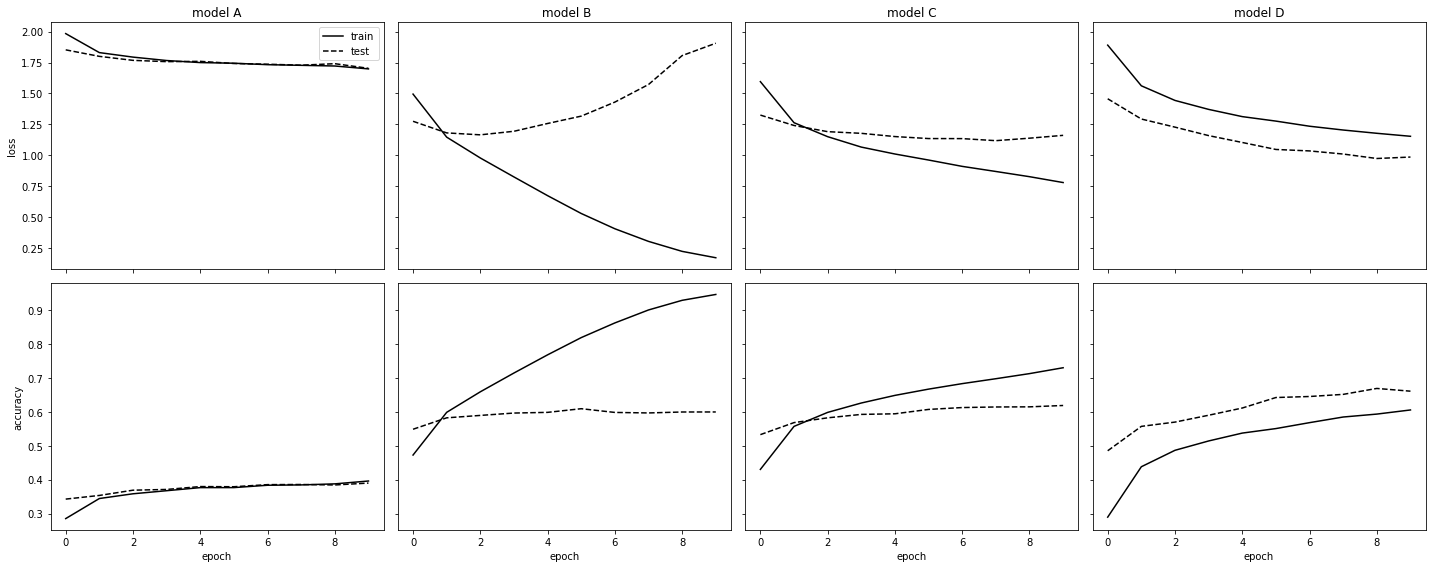

In [19]:
fig, ax = plt.subplots(2,len(histories), figsize=(20,8), sharex=True, sharey='row')

ax[0,0].set_ylabel('loss')
ax[1,0].set_ylabel('accuracy')

for i in range(len(histories)):
  ax[-1,i].set_xlabel('epoch')
  ax[0,i].set_title(model_names[i])

for i,history in enumerate(histories):
  ax[0,i].plot(history.history['loss'], c='k', label = 'train')
  ax[0,i].plot(history.history['val_loss'], c='k', ls='--', label='test')
  ax[1,i].plot(history.history['accuracy'], c='k')
  ax[1,i].plot(history.history['val_accuracy'], c='k', ls='--')

ax[0,0].legend()

plt.tight_layout()
plt.show()

In [20]:
for i,model in enumerate(models):
  print('\nevaluate ' + model_names[i])
  model.evaluate(validation_generator)


evaluate model A
157/157 [==============================] - 1s 5ms/step - loss: 1.7032 - accuracy: 0.3898

evaluate  model B
157/157 [==============================] - 1s 5ms/step - loss: 1.9064 - accuracy: 0.5996

evaluate model C
157/157 [==============================] - 1s 5ms/step - loss: 1.1604 - accuracy: 0.6187

evaluate model D
157/157 [==============================] - 1s 5ms/step - loss: 0.9847 - accuracy: 0.6609


# fit models to augmented data

In [21]:
models_aug = [make_model('A'), make_model('B'), make_model('C'), make_model('D')]
model_names = ['model A (aug)', ' model B (aug)', 'model C (aug)', 'model D (aug)']

In [22]:
augment = True
train_generator, validation_generator = train_val_generators(X_train, Y_train, X_val, Y_val, augment)

In [23]:
histories_aug = []

for i,model in enumerate(models_aug):

  print('\nfit ' + model_names[i])

  history = model.fit(train_generator, validation_data=validation_generator, epochs=10, callbacks = myCallback())

  histories_aug.append(history)


fit model A (aug)
Epoch 1/10
782/782 [==============================] - 23s 29ms/step - loss: 1.9497 - accuracy: 0.2953 - val_loss: 1.8513 - val_accuracy: 0.3443
Epoch 2/10
782/782 [==============================] - 23s 29ms/step - loss: 1.8369 - accuracy: 0.3453 - val_loss: 1.7745 - val_accuracy: 0.3663
Epoch 3/10
782/782 [==============================] - 23s 30ms/step - loss: 1.7964 - accuracy: 0.3615 - val_loss: 1.7672 - val_accuracy: 0.3782
Epoch 4/10
782/782 [==============================] - 22s 28ms/step - loss: 1.7814 - accuracy: 0.3685 - val_loss: 1.7510 - val_accuracy: 0.3767
Epoch 5/10
782/782 [==============================] - 22s 28ms/step - loss: 1.7732 - accuracy: 0.3680 - val_loss: 1.7797 - val_accuracy: 0.3573
Epoch 6/10
782/782 [==============================] - 22s 29ms/step - loss: 1.7583 - accuracy: 0.3765 - val_loss: 1.7080 - val_accuracy: 0.3858
Epoch 7/10
782/782 [==============================] - 22s 28ms/step - loss: 1.7483 - accuracy: 0.3804 - val_loss: 1.6

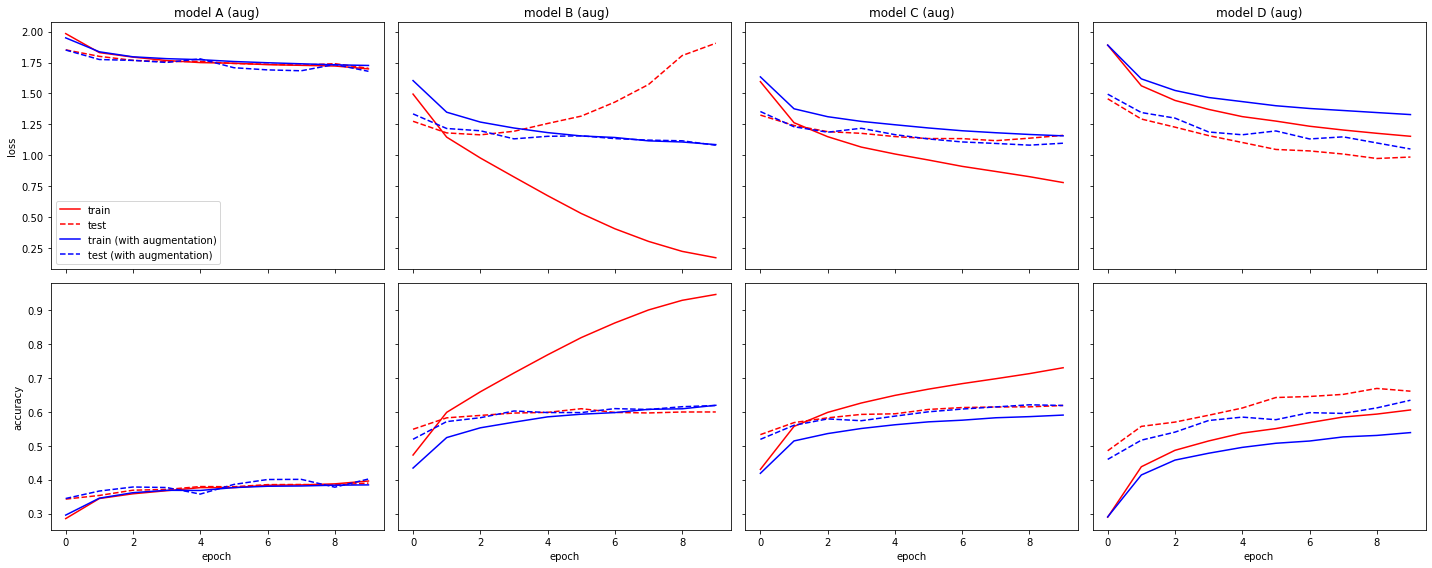

In [24]:
fig, ax = plt.subplots(2,len(histories), figsize=(20,8), sharex=True, sharey='row')

ax[0,0].set_ylabel('loss')
ax[1,0].set_ylabel('accuracy')

for i in range(len(histories)):
  ax[-1,i].set_xlabel('epoch')
  ax[0,i].set_title(model_names[i])

for i,history in enumerate(histories):
  ax[0,i].plot(history.history['loss'], c='r', label = 'train')
  ax[0,i].plot(history.history['val_loss'], c='r', ls='--', label='test')
  ax[1,i].plot(history.history['accuracy'], c='r')
  ax[1,i].plot(history.history['val_accuracy'], c='r', ls='--')


for i,history in enumerate(histories_aug):
  ax[0,i].plot(history.history['loss'], c='b', label = 'train (with augmentation)')
  ax[0,i].plot(history.history['val_loss'], c='b', ls='--', label='test (with augmentation)')
  ax[1,i].plot(history.history['accuracy'], c='b')
  ax[1,i].plot(history.history['val_accuracy'], c='b', ls='--')

ax[0,0].legend()

plt.tight_layout()
plt.show()

# plot model predictions

In [48]:
classes = models[3].predict(np.expand_dims(X_val, axis=-1), batch_size=32)

Y_model = np.argmax(classes, axis=1)

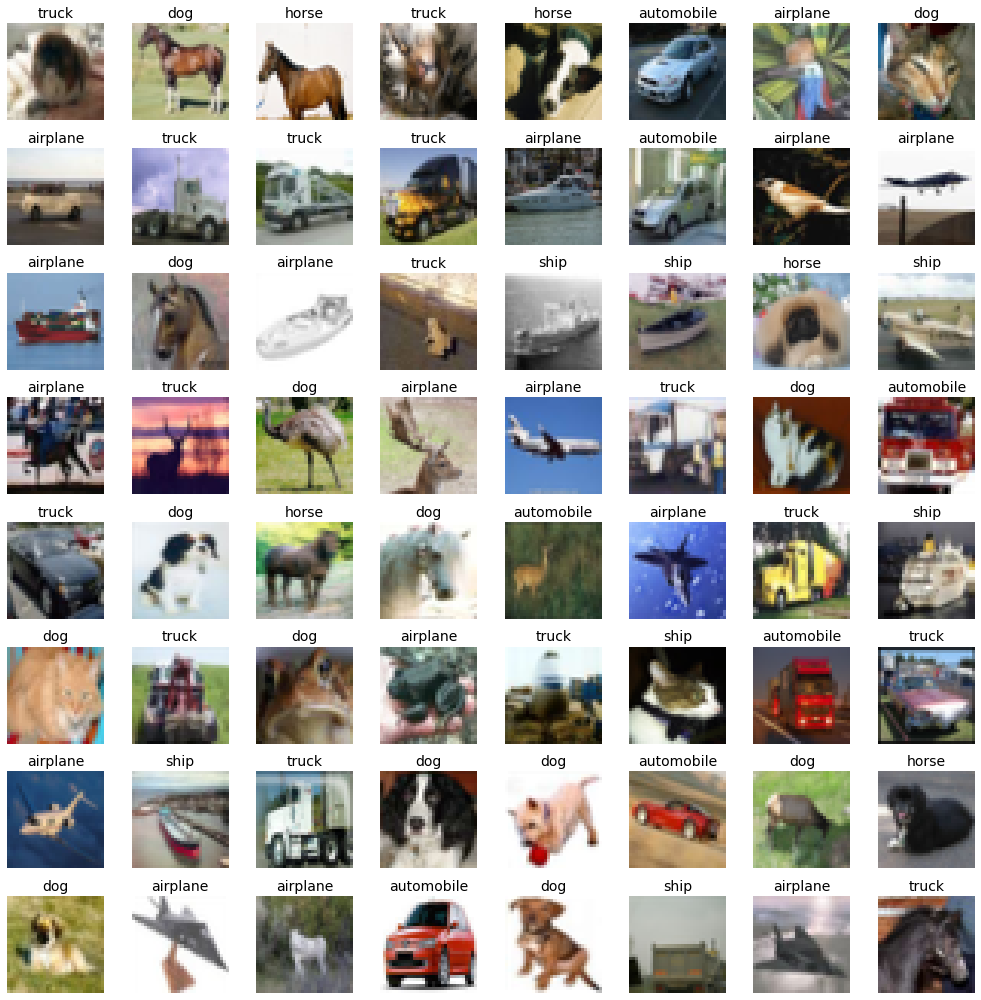

In [49]:
fig, ax = plt.subplots(8,8, figsize=(14,14))

imgID = 200
for ix in range(8):
    for iy in range(8):
        
        #if Y_model[imgID]==0:
        #    title = class1_name
        #else:
        #    title = class2_name

        title = class_names[Y_model_test[imgID]]

        ax[iy, ix].set_title(title, fontsize=14)
        
        ax[iy, ix].imshow(X_val[imgID], cmap=plt.get_cmap('gray'))
        
        ax[iy, ix].axis('off')
        
        imgID+=1
                

plt.tight_layout()            
plt.show()